# Analysis of My Apple Music Library

In [1]:
import numpy as np
import pandas as pd
import requests
import json
import os
import dotenv
import seaborn as sns
import matplotlib.pyplot as plt
import sys
import streamlit as st
import lyricsgenius # a wrapper around requests that works specifically with the Genius API
sys.tracebacklimit = 0 # turn off the error tracebacks

In [2]:
dailyPlay = pd.read_csv('AppleMusicData/Apple Music - Play History Daily Tracks.csv')
topContent = pd.read_csv('AppleMusicData/Apple Music - Top Content.csv')
favs = pd.read_csv('AppleMusicData/Apple Music - Favorites.csv')
libraryTracks = pd.read_json('AppleMusicData/Apple Music Library Tracks.json')
libraryTracks = libraryTracks.drop(columns=['Sort Composer'])

/var/folders/yt/vc06mr81367d93jqy5fmf0c40000gn/T/ipykernel_59427/1193043505.py:1: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  dailyPlay = pd.read_csv('AppleMusicData/Apple Music - Play History Daily Tracks.csv')


In [51]:
print(favs['Favorite Type'].unique())
favs = favs[favs['Favorite Type'] != 'Unknown']
favAlbums = favs[favs['Favorite Type'] == 'Album']
favSongs = favs[favs['Favorite Type'] == 'Song']
favPlaylists = favs[favs['Favorite Type'] == 'Playlist']
favArtists =  favs[favs['Favorite Type'] == 'Artist']

['Artist' 'Song' 'Unknown' 'Playlist' 'Album']


In [52]:
print(dailyPlay['Media type'].unique())
print(dailyPlay['Ignore For Recommendations'].unique())
print(dailyPlay['Ignore For Recommendations'] == True)
for colunm in dailyPlay.columns:
    print(colunm, dailyPlay[colunm].isna().sum())

[nan 'AUDIO' 'VIDEO']
[nan False True]
0         False
1         False
2         False
3         False
4         False
          ...  
248521    False
248522    False
248523    False
248524    False
248525    False
Name: Ignore For Recommendations, Length: 248526, dtype: bool
Country 0
Track Identifier 0
Media type 5640
Date Played 0
Hours 0
Play Duration Milliseconds 0
End Reason Type 0
Source Type 0
Play Count 0
Skip Count 0
Ignore For Recommendations 5840
Track Reference 14507
Track Description 17


In [56]:
dailyPlay[dailyPlay['Media type'] == 'VIDEO'].value_counts()
dailyPlay[dailyPlay['Track Description'].isna()]
dailyPlayCleaned = dailyPlay[~((dailyPlay['Media type'] == 'VIDEO') & (dailyPlay['Track Description'].isna()))]
dailyPlayCleaned = dailyPlay.drop(columns=['Ignore For Recommendations',  'Track Reference'])
dailyPlayCleaned['Media type'].fillna('AUDIO', inplace=True)
dailyPlayCleaned['Date Played'] = pd.to_datetime(dailyPlayCleaned['Date Played'], format='%Y%m%d')

/var/folders/yt/vc06mr81367d93jqy5fmf0c40000gn/T/ipykernel_41032/217504134.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  dailyPlayCleaned['Media type'].fillna('AUDIO', inplace=True)


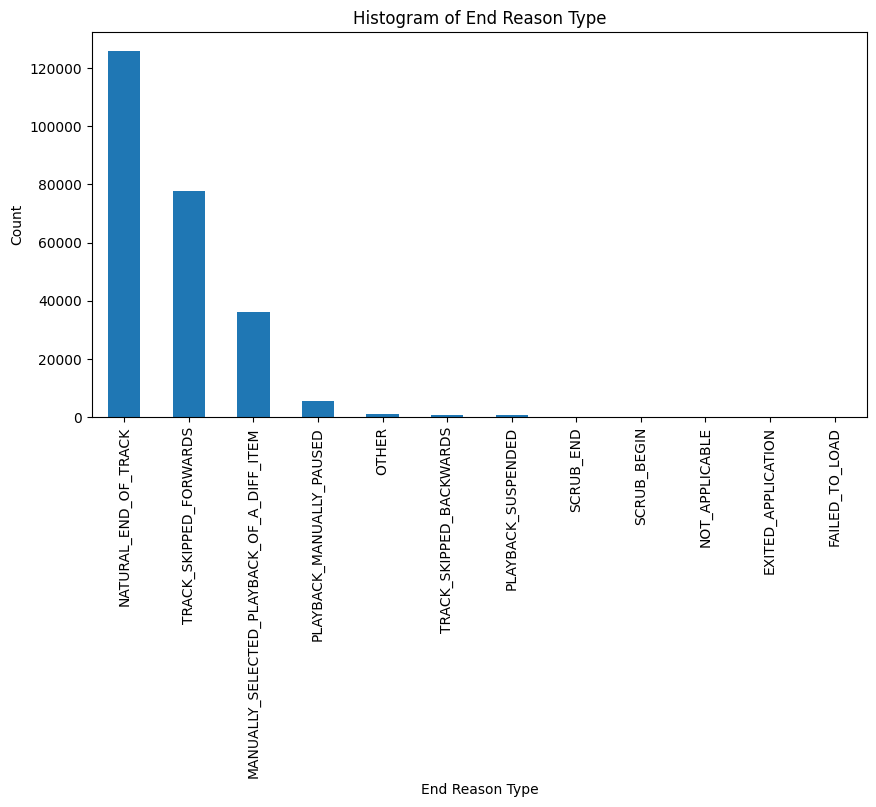

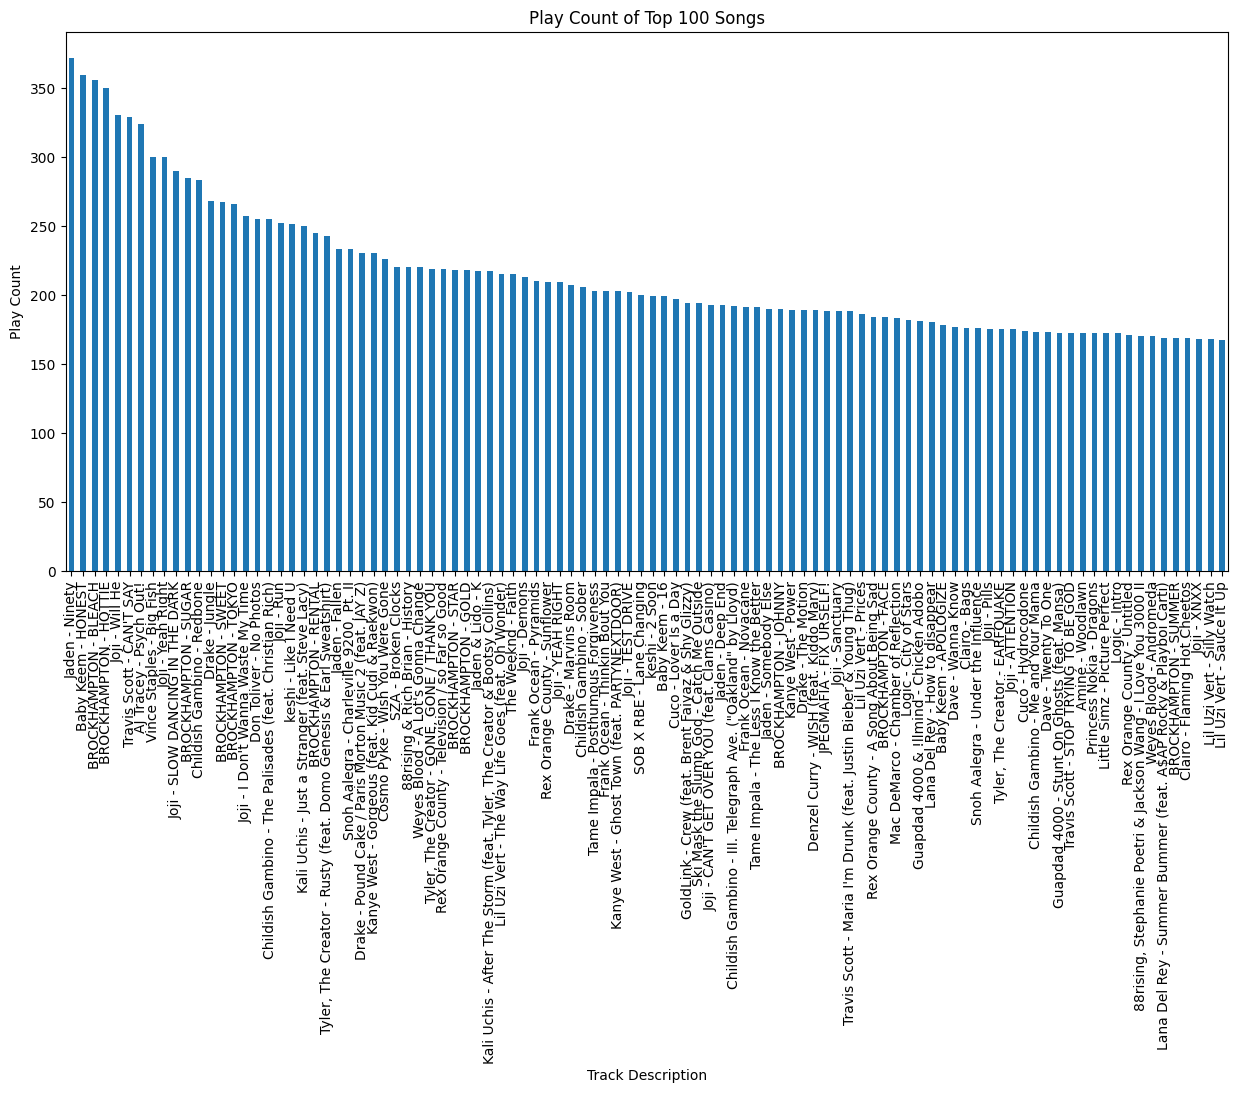

In [63]:
dailyPlayCleaned# Histogram of "End Reason Type"
plt.figure(figsize=(10, 5))
dailyPlayCleaned['End Reason Type'].value_counts().plot(kind='bar')
plt.title('Histogram of End Reason Type')
plt.xlabel('End Reason Type')
plt.ylabel('Count')
plt.show()

top_100_songs = dailyPlayCleaned['Track Description'].value_counts().head(100)

# Plot the graph
plt.figure(figsize=(15, 7))
top_100_songs.plot(kind='bar')
plt.title('Play Count of Top 100 Songs')
plt.xlabel('Track Description')
plt.ylabel('Play Count')
plt.xticks(rotation=90)
plt.show()


In [71]:
dailyPlayCleaned[(dailyPlayCleaned['Track Description'] == 'BROCKHAMPTON - HOTTIE') & (dailyPlayCleaned['End Reason Type'] == 'NATURAL_END_OF_TRACK')].head(15)

,Country,Track Identifier,Media type,Date Played,Hours,Play Duration Milliseconds,End Reason Type,Source Type,Play Count,Skip Count,Track Description
11399,United States,1322094235,AUDIO,2018-04-26,"2, 11, 12, 18, 19",646607,NATURAL_END_OF_TRACK,IPHONE,6,1,BROCKHAMPTON - HOTTIE
11523,United States,1322094235,AUDIO,2018-04-27,"4, 21",394414,NATURAL_END_OF_TRACK,IPHONE,2,0,BROCKHAMPTON - HOTTIE
11706,United States,1322094235,AUDIO,2018-04-28,17,197207,NATURAL_END_OF_TRACK,IPHONE,1,0,BROCKHAMPTON - HOTTIE
11803,United States,1322094235,AUDIO,2018-04-29,2,197207,NATURAL_END_OF_TRACK,IPHONE,1,0,BROCKHAMPTON - HOTTIE
11963,United States,1322094235,AUDIO,2018-05-02,"3, 12, 15",489724,NATURAL_END_OF_TRACK,IPHONE,3,0,BROCKHAMPTON - HOTTIE
12188,United States,1322094235,AUDIO,2018-05-04,18,197207,NATURAL_END_OF_TRACK,IPHONE,2,0,BROCKHAMPTON - HOTTIE
12234,United States,1322094235,AUDIO,2018-05-05,3,197207,NATURAL_END_OF_TRACK,IPHONE,1,0,BROCKHAMPTON - HOTTIE
12307,United States,1322094235,AUDIO,2018-05-07,"11, 12",197207,NATURAL_END_OF_TRACK,IPHONE,1,1,BROCKHAMPTON - HOTTIE
12400,United States,1322094235,AUDIO,2018-05-08,13,191782,NATURAL_END_OF_TRACK,IPHONE,1,0,BROCKHAMPTON - HOTTIE
12495,United States,1322094235,AUDIO,2018-05-09,"18, 19",394414,NATURAL_END_OF_TRACK,IPHONE,2,0,BROCKHAMPTON - HOTTIE


In [33]:
for colunm in libraryTracks.columns:
    print(colunm, libraryTracks[colunm].isna().sum())

Content Type 0
Track Identifier 0
Title 0
Sort Name 782
Artist 20
Sort Artist 854
Composer 1680
Is Part of Compilation 28
Album 47
Sort Album 834
Album Artist 289
Genre 35
Grouping 10505
Comments 10284
Track Year 9
Track Number On Album 19
Track Count On Album 19
Disc Number Of Album 40
Disc Count Of Album 19
Beats Per Minute 10542
Track Duration 6
Track Play Count 0
Date Added To Library 0
Date Added To iCloud Music Library 0
Last Modified Date 0
Last Played Date 2182
Purchase Date 11622
Rating 8808
Album Rating 8807
Skip Count 0
Date of Last Skip 6436
Is Purchased 0
Audio File Extension 3
Remember Playback Position 10165
Album Like Rating 8628
Track Like Rating 10404
Album Rating Method 8916
Is Checked 0
Work Name 10541
Movement Name 10553
Movement Number 10553
Movement Count 10553
Release Date 930
Display Work Name 10169
Purchased Track Identifier 861
Audio Matched Track Identifier 11640
Tag Matched Track Identifier 8486
Apple Music Track Identifier 724
Favorite Status - Track 11703

In [9]:
libraryTracksCleaned = libraryTracks.drop(columns=['Audio Matched Track Identifier', 'Grouping', 'Comments', 'Disc Number Of Album', 'Disc Number Of Album', 
                                                   'Purchase Date', 'Rating', 'Beats Per Minute', 'Album Like Rating', 'Track Like Rating', 'Work Name', 'Movement Name', 
                                                   'Movement Number', 'Movement Count', 'Display Work Name', 'Purchased Track Identifier','Audio Matched Track Identifier',
                                                   'Tag Matched Track Identifier','Apple Music Track Identifier', 'Favorite Status - Track','Favorite Date - Track',
                                                   'Favorite Date - Track', 'Favorite Status - Album', 'Playlist Only Track','Favorite Status - Album', 'Sort Album Artist',
                                                   'Track Like Rating', 'Album Like Rating','Remember Playback Position', 'Album Rating', 'Album Rating Method'])

In [11]:
for colunm in libraryTracksCleaned.columns:
    print(colunm, libraryTracksCleaned[colunm].isna().sum())
#libraryTracksCleaned[libraryTracksCleaned['Track Year'].isna()]
libraryTracksCleaned['Track Year'].fillna(2025, inplace=True)


Content Type 0
Track Identifier 0
Title 0
Sort Name 782
Artist 20
Sort Artist 854
Composer 1680
Is Part of Compilation 28
Album 47
Sort Album 834
Album Artist 289
Genre 35
Track Year 0
Track Number On Album 19
Track Count On Album 19
Disc Count Of Album 19
Track Duration 6
Track Play Count 0
Date Added To Library 0
Date Added To iCloud Music Library 0
Last Modified Date 0
Last Played Date 2182
Skip Count 0
Date of Last Skip 6436
Is Purchased 0
Audio File Extension 3
Is Checked 0
Release Date 930
Copyright 1064


/var/folders/yt/vc06mr81367d93jqy5fmf0c40000gn/T/ipykernel_59427/2333034475.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  libraryTracksCleaned['Track Year'].fillna(2025, inplace=True)


,Content Type,Track Identifier,Title,Sort Name,Artist,Sort Artist,Composer,Is Part of Compilation,Album,Sort Album,...,Date Added To iCloud Music Library,Last Modified Date,Last Played Date,Skip Count,Date of Last Skip,Is Purchased,Audio File Extension,Is Checked,Release Date,Copyright
11813,Song,183073314,Here is Someone,Here is Someone,Japanese Breakfast,Japanese Breakfast,Michelle Zauner,0.0,For Melancholy Brunettes (& sad women),For Melancholy Brunettes (& sad women),...,2025-01-10T16:16:29Z,2025-01-10T16:16:29Z,NaN,0,NaN,False,m4a,False,NaN,℗ 2025 Dead Oceans
11814,Song,183073318,Orlando in Love,Orlando in Love,Japanese Breakfast,Japanese Breakfast,Michelle Zauner,0.0,For Melancholy Brunettes (& sad women),For Melancholy Brunettes (& sad women),...,2025-01-10T16:16:29Z,2025-01-10T16:16:29Z,2025-01-12T05:26:20Z,0,NaN,False,m4a,False,2025-01-07T08:00:00Z,℗ 2025 Dead Oceans
11815,Song,183073322,Honey Water,Honey Water,Japanese Breakfast,Japanese Breakfast,Michelle Zauner,0.0,For Melancholy Brunettes (& sad women),For Melancholy Brunettes (& sad women),...,2025-01-10T16:16:29Z,2025-01-10T16:16:29Z,NaN,0,NaN,False,m4a,False,NaN,℗ 2025 Dead Oceans
11816,Song,183073326,Mega Circuit,Mega Circuit,Japanese Breakfast,Japanese Breakfast,Michelle Zauner,0.0,For Melancholy Brunettes (& sad women),For Melancholy Brunettes (& sad women),...,2025-01-10T16:16:29Z,2025-01-10T16:16:29Z,NaN,0,NaN,False,m4a,False,NaN,℗ 2025 Dead Oceans
11817,Song,183073330,Little Girl,Little Girl,Japanese Breakfast,Japanese Breakfast,Michelle Zauner,0.0,For Melancholy Brunettes (& sad women),For Melancholy Brunettes (& sad women),...,2025-01-10T16:16:29Z,2025-01-10T16:16:29Z,NaN,0,NaN,False,m4a,False,NaN,℗ 2025 Dead Oceans
11818,Song,183073334,Leda,Leda,Japanese Breakfast,Japanese Breakfast,Michelle Zauner,0.0,For Melancholy Brunettes (& sad women),For Melancholy Brunettes (& sad women),...,2025-01-10T16:16:29Z,2025-01-10T16:16:29Z,NaN,0,NaN,False,m4a,False,NaN,℗ 2025 Dead Oceans
11819,Song,183073538,Picture Window,Picture Window,Japanese Breakfast,Japanese Breakfast,Michelle Zauner,0.0,For Melancholy Brunettes (& sad women),For Melancholy Brunettes (& sad women),...,2025-01-10T16:16:29Z,2025-01-10T16:16:29Z,NaN,0,NaN,False,m4a,False,NaN,℗ 2025 Dead Oceans
11820,Song,183073542,Men in Bars (feat. Jeff Bridges),Men in Bars (feat. Jeff Bridges),Japanese Breakfast,Japanese Breakfast,Michelle Zauner,0.0,For Melancholy Brunettes (& sad women),For Melancholy Brunettes (& sad women),...,2025-01-10T16:16:29Z,2025-01-10T16:16:29Z,NaN,0,NaN,False,m4a,False,NaN,℗ 2025 Dead Oceans
11821,Song,183073546,Winter in LA,Winter in LA,Japanese Breakfast,Japanese Breakfast,Michelle Zauner,0.0,For Melancholy Brunettes (& sad women),For Melancholy Brunettes (& sad women),...,2025-01-10T16:16:29Z,2025-01-10T16:16:29Z,NaN,0,NaN,False,m4a,False,NaN,℗ 2025 Dead Oceans
11822,Song,183073550,Magic Mountain,Magic Mountain,Japanese Breakfast,Japanese Breakfast,Michelle Zauner,0.0,For Melancholy Brunettes (& sad women),For Melancholy Brunettes (& sad women),...,2025-01-10T16:16:29Z,2025-01-10T16:16:29Z,NaN,0,NaN,False,m4a,False,NaN,℗ 2025 Dead Oceans


In [14]:
# Condition to filter rows where the title matches
condition = libraryTracksCleaned['Title'] == 'Got This Money (Acoustic @ Ace Hotel)'

# Fill NaN values in "Sort Name" and "Artist" columns with "Childish Gambino"
libraryTracksCleaned.loc[condition, 'Sort Name'] = libraryTracksCleaned.loc[condition, 'Sort Name'].fillna('Childish Gambino')
libraryTracksCleaned.loc[condition, 'Artist'] = libraryTracksCleaned.loc[condition, 'Artist'].fillna('Childish Gambino')
libraryTracksCleaned[(libraryTracksCleaned['Sort Album'].isna()) & (libraryTracksCleaned['Album'].isna())]

,Content Type,Track Identifier,Title,Sort Name,Artist,Sort Artist,Composer,Is Part of Compilation,Album,Sort Album,...,Date Added To iCloud Music Library,Last Modified Date,Last Played Date,Skip Count,Date of Last Skip,Is Purchased,Audio File Extension,Is Checked,Release Date,Copyright
332,Song,182863390,Forgot about Dre,NaN,Dr. Dre.,NaN,NaN,0.0,NaN,NaN,...,2018-02-18T18:33:03Z,2017-12-11T22:38:10Z,2023-05-22T00:44:42Z,1,2019-04-06T18:24:28Z,False,m4a,False,NaN,NaN
470,Song,182865942,Whatever I am,NaN,Eminem,NaN,NaN,0.0,NaN,NaN,...,2018-02-18T18:33:03Z,2017-12-11T22:38:06Z,2019-04-26T01:46:25Z,0,NaN,False,m4a,False,NaN,NaN
515,Song,182866722,Chapter 1 test Speaking section,NaN,NaN,NaN,NaN,0.0,NaN,NaN,...,2018-02-18T18:33:03Z,2017-11-20T19:38:16Z,Invalid,0,NaN,False,m4a,False,NaN,NaN
519,Song,182866738,Cafeteria,NaN,Jakey,NaN,NaN,0.0,NaN,NaN,...,2018-02-18T18:33:03Z,2017-12-11T21:37:42Z,2024-12-09T21:09:26Z,2,2022-01-18T08:32:37Z,False,mp3,False,NaN,NaN
560,Song,182867502,Pronunciation practice,NaN,NaN,NaN,NaN,0.0,NaN,NaN,...,2018-02-18T18:33:03Z,2017-09-13T19:20:02Z,Invalid,0,NaN,False,m4a,False,NaN,NaN
1226,Music Video,182879766,Heartless,Heartless,Kanye West,Kanye West,NaN,NaN,NaN,NaN,...,2018-03-18T17:59:54Z,2018-03-18T17:59:54Z,NaN,0,NaN,False,m4v,False,2008-01-01T08:00:00Z,"℗ 2008 Roc-A-Fella Records, LLC"
1301,Song,182881066,Got This Money (Acoustic @ Ace Hotel),Childish Gambino,Childish Gambino,NaN,NaN,0.0,NaN,NaN,...,2018-04-01T04:27:48Z,2011-09-20T16:52:24Z,2019-07-16T19:15:52Z,4,2019-04-09T11:53:27Z,False,mp3,False,NaN,NaN
1306,Song,182881286,13 Put It In My Video,NaN,Childish Gambino,NaN,NaN,0.0,NaN,NaN,...,2018-04-01T04:27:48Z,2011-09-20T16:51:52Z,NaN,0,NaN,False,mp3,False,NaN,NaN
1307,Song,182881290,14 These Girls ft. Garfunkel and Oates,NaN,Childish Gambino,NaN,NaN,0.0,NaN,NaN,...,2018-04-01T04:27:48Z,2011-09-20T16:51:52Z,NaN,0,NaN,False,mp3,False,NaN,NaN
1308,Song,182881294,15 The Last,NaN,Childish Gambino,NaN,NaN,0.0,NaN,NaN,...,2018-04-01T04:27:48Z,2011-09-20T16:51:52Z,NaN,0,NaN,False,mp3,False,NaN,NaN
